In [2]:
import numpy as np
from scipy import optimize
from typing import List, Tuple, Dict
import warnings
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
class SPOT:
    def __init__(self, q: float = 1e-3):
        self.q = q
        self.n = None
        self.init_threshold = None
        self.extreme_quantile = None
        self.peaks = []
        self.n_obs = 0
        self.gamma = None
        self.sigma = None
        
    def _grimshaw_trick(self, peaks: List[float]) -> Tuple[float, float]:
        if len(peaks) < 2:
            raise ValueError("Need at least 2 peaks for GPD fit")
            
        sorted_peaks = sorted(peaks)
        n_peaks = len(peaks)

        def u(x):
            return np.mean([1 / (1 + x * yi) for yi in peaks])
        
        def v(x):
            return 1 + np.mean([np.log(1 + x * yi) for yi in peaks])
        
        def w(x):
            return u(x) * v(x) - 1

        y_min = min(peaks)
        y_max = max(peaks)
        y_mean = np.mean(peaks)

        x_max = 2 * (y_mean - y_min) / (y_min ** 2)

        eps = 1e-8

        candidates = []

        try:
            result1 = optimize.minimize_scalar(
                lambda x: abs(w(x)), 
                bounds=(-1/y_max + eps, -eps),
                method='bounded'
            )
            if abs(w(result1.x)) < 1e-6:
                candidates.append(result1.x)
        except:
            pass
 
        try:
            result2 = optimize.minimize_scalar(
                lambda x: abs(w(x)),
                bounds=(2 * (y_mean - y_min) / (y_mean * y_min), x_max),
                method='bounded'
            )
            if abs(w(result2.x)) < 1e-6:
                candidates.append(result2.x)
        except:
            pass

        candidates.append(0)

        best_likelihood = -np.inf
        best_gamma = None
        best_sigma = None
        
        for x_star in candidates:
            try:
                gamma = v(x_star) - 1
                sigma = gamma / x_star if x_star != 0 else np.mean(peaks)

                if gamma != 0:
                    log_likelihood = -n_peaks * np.log(sigma) - (1 + 1/gamma) * \
                                   sum(np.log(1 + gamma * yi / sigma) for yi in peaks)
                else:
                    log_likelihood = -n_peaks * np.log(sigma) - sum(yi/sigma for yi in peaks)
                    
                if log_likelihood > best_likelihood:
                    best_likelihood = log_likelihood
                    best_gamma = gamma
                    best_sigma = sigma
                    
            except:
                continue
                
        if best_gamma is None:
            warnings.warn("Grimshaw optimization failed, using method of moments")
            m1 = np.mean(peaks)
            m2 = np.mean([p**2 for p in peaks])
            best_gamma = 0.5 * (m1**2 / m2 - 1)
            best_sigma = 0.5 * m1 * (m1**2 / m2 + 1)
            
        return best_gamma, best_sigma
    
    def _compute_quantile(self, gamma: float, sigma: float, 
                         n: int, n_peaks: int) -> float:
        if gamma != 0:
            return self.init_threshold + (sigma / gamma) * \
                   ((self.q * n / n_peaks) ** (-gamma) - 1)
        else:
            return self.init_threshold - sigma * np.log(self.q * n / n_peaks)
    
    def initialize(self, data: np.ndarray, threshold_percentile: float = 98):
        self.n = len(data)
        self.n_obs = self.n

        self.init_threshold = np.percentile(data, threshold_percentile)

        self.peaks = [x - self.init_threshold for x in data 
                     if x > self.init_threshold]
        
        if len(self.peaks) < 2:
            raise ValueError(f"Not enough peaks. Try lowering threshold_percentile. "
                           f"Got {len(self.peaks)} peaks.")

        self.gamma, self.sigma = self._grimshaw_trick(self.peaks)

        self.extreme_quantile = self._compute_quantile(
            self.gamma, self.sigma, self.n_obs, len(self.peaks)
        )
        
        return self
    
    def predict(self, value: float) -> Dict[str, any]:
        self.n_obs += 1
        result = {
            'value': value,
            'threshold': self.extreme_quantile,
            'anomaly': False
        }
        
        if value > self.extreme_quantile:
            result['anomaly'] = True
        elif value > self.init_threshold:
            excess = value - self.init_threshold
            self.peaks.append(excess)
            
            self.gamma, self.sigma = self._grimshaw_trick(self.peaks)
            
            self.extreme_quantile = self._compute_quantile(
                self.gamma, self.sigma, self.n_obs, len(self.peaks)
            )
            result['threshold'] = self.extreme_quantile
            
        return result
    
    def fit_predict(self, initial_data: np.ndarray, 
                   stream_data: np.ndarray) -> List[Dict]:
        self.initialize(initial_data)
        
        results = []
        for value in stream_data:
            results.append(self.predict(value))
            
        return results

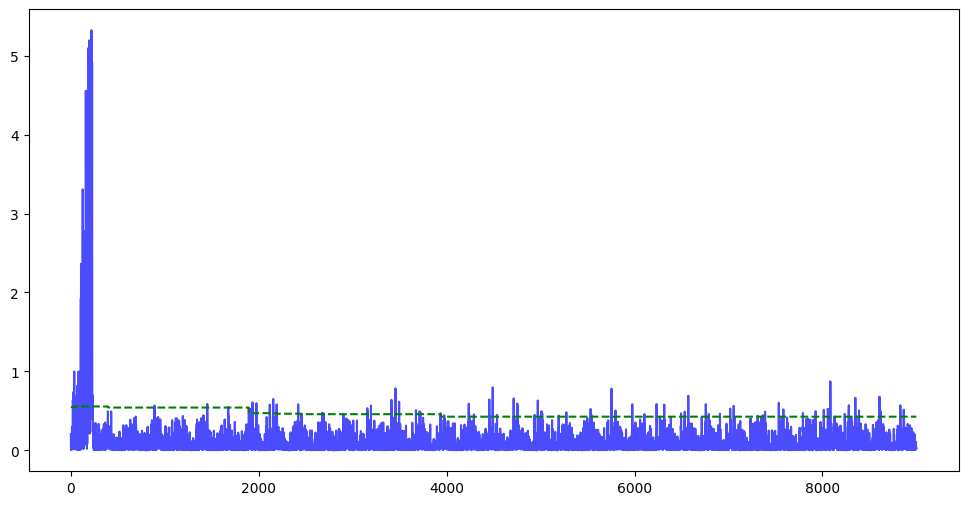

In [4]:
if __name__ == "__main__":
    data = pd.read_csv("Data/anomaly_scores_dada.csv")

    init_data = data.iloc[:1000, 1]
    stream_data = data.iloc[1000:, 1]

    detector = SPOT(q=1e-2)
    results = detector.fit_predict(init_data, stream_data)

    values = [r['value'] for r in results]
    thresholds = [r['threshold'] for r in results]
    anomalies = [(i, r['value']) for i, r in enumerate(results) if r['anomaly']]

    plt.figure(figsize=(12, 6))
    plt.plot(values, 'b-', alpha=0.7, label='Data')
    plt.plot(thresholds, 'g--', label='Anomaly threshold')

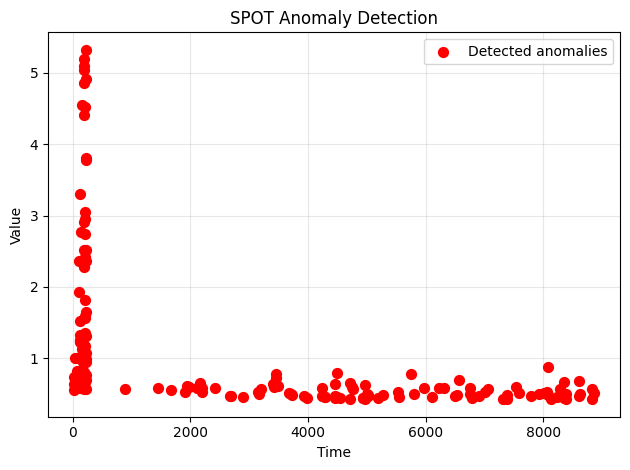

In [5]:
if anomalies:
        anomaly_indices, anomaly_values = zip(*anomalies)
        plt.scatter(anomaly_indices, anomaly_values, 
                   color='red', s=50, label='Detected anomalies', zorder=5)
    
        plt.xlabel('Time')
        plt.ylabel('Value')
        plt.title('SPOT Anomaly Detection')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

In [6]:
print(f"Total observations: {len(stream_data)}")
print(f"Anomalies detected: {len(anomalies)}")
print(f"Detection rate: {len(anomalies)/len(stream_data)*100:.2f}%")

Total observations: 9000
Anomalies detected: 178
Detection rate: 1.98%
